In [1]:
import numpy as np
import datetime as dt
import tensorflow as tf
import time
import os
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Import whole N-MNIST Dataset
def load_NMNIST(path):
    """
    """
    xs_train = []
    ys_train = []
    xs_test = []
    ys_test = []

    for class_index in range(0, 10):
        for (root, dirs, dat_files) in os.walk('{0}/n_Train_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                single_X = np.fromfile('{0}/n_Train_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32)
                xs_train.append(single_X)
                ys_train.append(class_index)

        for (root, dirs, dat_files) in os.walk('{0}/n_Test_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                xs_test.append(np.fromfile('{0}/n_Test_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32))
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Yte = np.array(ys_test)

    return Xtr, Ytr, Xte, Yte

In [3]:
dataset_class_path = '/Users/brunocalogero/Desktop/LowPowerActionRecognition/CNN/NMNIST/datasets'
X_train, Y_train, X_test, Y_test = load_NMNIST(dataset_class_path)

In [4]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', Y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

Training data shape:  (60000, 2312)
Training labels shape:  (60000,)
Test data shape:  (10000, 2312)
Test labels shape:  (10000,)


In [5]:
# turn X training values into (60000, 34, 34, 2)
X_trainy = X_train.reshape(60000, 34, 34, 2)
# turn X test values into (10000, 34, 34, 2)
X_testy = X_test.reshape(10000, 34, 34, 2)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_trainy.shape)
print('Test data shape: ', X_testy.shape)


Training data shape:  (60000, 34, 34, 2)
Test data shape:  (10000, 34, 34, 2)


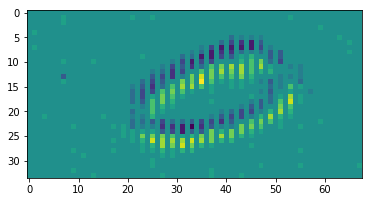

In [6]:
# quick sanity check to make sure our data looks like what we want as a 2D array, thus meaning our 34x34x2 is correct
plt.imshow(X_train[0].reshape(34,68))

In [7]:
# hesitant about the shuffleness around here
num_training = 59000
num_validation = 1000
num_test = 10000

mask = range(num_training, num_training + num_validation)
X_val = X_trainy[mask]
y_val = Y_train[mask]
mask = range(num_training)
X_trainy = X_trainy[mask]
Y_train = Y_train[mask]
mask = range(num_test)
X_testy = X_testy[mask]
Y_test = Y_test[mask]

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_trainy.shape)
print('Test data shape: ', X_testy.shape)
print('Validation data shape: ', X_val.shape)

Training data shape:  (59000, 34, 34, 2)
Test data shape:  (10000, 34, 34, 2)
Validation data shape:  (1000, 34, 34, 2)


In [8]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_trainy, Y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_testy, Y_test, batch_size=64)

In [9]:
print(train_dset)

In [10]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /cpu:0


In [11]:
def check_accuracy(sess, dset, x, scores, is_training=None):
    """
    Check accuracy on a classification model.
    
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

In [72]:
def model_init_fn(inputs):
    channel_1, channel_2, channel_3, channel_4,  num_classes =  128, 64, 32, 16, 10
    # consider using initializer for conv layers (variance scaling)
    
    conv1 = tf.layers.conv2d(inputs, channel_1, (3, 3), padding='SAME', activation=tf.nn.leaky_relu)
    bn1 = tf.layers.batch_normalization(conv1)
    pool1 = tf.layers.max_pooling2d(bn1, 2, 2)
    
    # maybe add a dropout at some point here
    
    conv2 = tf.layers.conv2d(pool1, channel_2, (3, 3), padding='SAME', activation=tf.nn.leaky_relu)
    bn2 = tf.layers.batch_normalization(conv2)
    pool2 = tf.layers.max_pooling2d(bn2, 2, 2)
    
    conv3 = tf.layers.conv2d(pool2, channel_3, (3, 3), padding='SAME', activation=tf.nn.leaky_relu)
    bn3 = tf.layers.batch_normalization(conv3)
    pool3 = tf.layers.max_pooling2d(bn3, 2, 2)
    
    conv4 = tf.layers.conv2d(pool3, channel_4, (3, 3), padding='SAME', activation=tf.nn.leaky_relu)
    bn4 = tf.layers.batch_normalization(conv4)
    pool4 = tf.layers.max_pooling2d(bn4, 2, 2)
    
    conv4_flattened = tf.layers.flatten(pool4)
    fc = tf.layers.dense(conv4_flattened, num_classes)
    return fc


learning_rate = 0.01 
tf.reset_default_graph()
with tf.device(device):
    x = tf.placeholder(tf.float32, [None, 34, 34, 2])
    y = tf.placeholder(tf.int32, [None])
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    scores = model_init_fn(x)
    loss   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    loss   = tf.reduce_mean(loss)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss)
        
print_every = 2
num_epochs = 20 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    t = 0
    for epoch in range(num_epochs):
        print('Starting epoch %d' % epoch)
        for x_np, y_np in train_dset:
            feed_dict = {x: x_np, y: y_np, is_training:1}
            loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss_np))
                check_accuracy(sess, val_dset, x, scores, is_training=is_training)
                print()
            t += 1

Starting epoch 0
Iteration 0, loss = 1.8345
Got 0 / 1000 correct (0.00%)

Iteration 700, loss = 0.0004
Got 0 / 1000 correct (0.00%)

Starting epoch 1
Iteration 1400, loss = 9.0964
Got 0 / 1000 correct (0.00%)

Starting epoch 2
Iteration 2100, loss = 0.0009
Got 0 / 1000 correct (0.00%)

Starting epoch 3
Iteration 2800, loss = 0.4081
Got 0 / 1000 correct (0.00%)

Iteration 3500, loss = 0.0004
Got 0 / 1000 correct (0.00%)

Starting epoch 4


KeyboardInterrupt: 

In [13]:
def model_init_fn(inputs):
    # Network architecture: (conv -> relu -> batchnorm -> maxpool) * 2 -> FC
    conv1 = tf.layers.conv2d(inputs, 32, (3, 3), padding='SAME', activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(conv1)
    pool1 = tf.layers.max_pooling2d(bn1, 2, 2)
    
    conv2 = tf.layers.conv2d(pool1, 64, (3, 3), padding='SAME', activation=tf.nn.relu)
    bn2 = tf.layers.batch_normalization(conv2)
    pool2 = tf.layers.max_pooling2d(bn2, 2, 2)
    
    conv2_flattened = tf.layers.flatten(pool2)
    
    fc = tf.layers.dense(conv2_flattened, 10)
    
    return fc


learning_rate = 5e-4
num_epoch = 10
tf.reset_default_graph()
with tf.device(device):
    is_training = tf.placeholder(tf.bool, name='is_training')
   
    # Set up placeholders for the data and labels
    x = tf.placeholder(tf.float32, [None, 34, 34, 2])
    y = tf.placeholder(tf.int32, [None])
    
    scores = model_init_fn(x)
    
    # Loss and optimization
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores))
   
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = optimizer.minimize(loss)




# Now we actually run the graph many times using the training data
with tf.Session() as sess:
    # Initialize variables that will live in the graph
    sess.run(tf.global_variables_initializer())
    for i in range(num_epoch):
      for t, (x_np, y_np) in enumerate(train_dset):
          # Run the graph on a batch of training data; recall that asking
          # TensorFlow to evaluate loss will cause an SGD step to happen.
          feed_dict = {x: x_np, y: y_np, is_training:1}
          loss_np, _ = sess.run([loss, train_step], feed_dict=feed_dict)

      print('Epoch %d, loss = %.4f' % (i, loss_np))
      check_accuracy(sess, val_dset, x, scores, is_training)

Epoch 0, loss = 0.0052
Got 1000 / 1000 correct (100.00%)
Epoch 1, loss = 0.0080
Got 1000 / 1000 correct (100.00%)
Epoch 2, loss = 0.0106
Got 1000 / 1000 correct (100.00%)
Epoch 3, loss = 0.0002
Got 1000 / 1000 correct (100.00%)
Epoch 4, loss = 0.0004
Got 1000 / 1000 correct (100.00%)
Epoch 5, loss = 0.0071
Got 1000 / 1000 correct (100.00%)


KeyboardInterrupt: 